# Desafio FADESP
## Processo seletivo Analista Bi
### Bruno Leitão

### Importando pacotes e dataset

In [1]:
import requests
import io
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import chardet # vou utilizar essa biblioteca pra verificar o encoding do dataset

In [2]:
# Desafio carregando direto do github
url = 'https://raw.githubusercontent.com/brunohleitao/desafio-fadesp-processo-seletivo/master/data/dataset_desafio_fadesp.csv'
response = requests.get(url)
csv_file = io.StringIO(response.content.decode('Windows-1252'))

df = pd.read_csv(csv_file)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

### Iniciando limpeza dos dados e preparando os dados

In [4]:
# verificando NaNs
mask = df.isna()
df_na = df.loc[mask.any(axis=1), mask.any(axis=0)]
df_na

,Postal Code
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
51283,NaN
51284,NaN
51286,NaN
51287,NaN


In [5]:
df.drop_duplicates(inplace=True)
df.fillna(value=0, inplace=True)

#### Padronizando dados

In [6]:
# Padronizando dados para verificação na próxima célula
df['Order Date'] = df['Order Date'].str.replace('-', '/')
df['Ship Date'] = df['Ship Date'].str.replace('-', '/')
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

In [7]:
pd.set_option('display.max_columns', None)
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,2011-01-01,2011-01-06,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,0.0,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.1400,35.46,Medium
1,22253,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,0.0,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.0360,9.72,Medium
2,48883,HU-2011-1220,2011-01-01,2011-01-05,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,0.0,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.6400,8.17,High
3,11731,IT-2011-3647632,2011-01-01,2011-01-05,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,0.0,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.0550,4.82,High
4,22255,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,0.0,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.7700,4.70,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,32593,CA-2014-115427,2014-12-31,2015-01-04,Standard Class,EB-13975,Erica Bern,Corporate,Fairfield,California,United States,94533.0,US,West,OFF-BI-10002103,Office Supplies,Binders,"Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl",13.904,2,0.2,4.5188,0.89,Medium
51286,47594,MO-2014-2560,2014-12-31,2015-01-05,Standard Class,LP-7095,Liz Preis,Consumer,Agadir,Souss-Massa-Draâ,Morocco,0.0,Africa,Africa,OFF-WIL-10001069,Office Supplies,Binders,"Wilson Jones Hole Reinforcements, Clear",3.990,1,0.0,0.4200,0.49,Medium
51287,8857,MX-2014-110527,2014-12-31,2015-01-02,Second Class,CM-12190,Charlotte Melton,Consumer,Managua,Managua,Nicaragua,0.0,LATAM,Central,OFF-LA-10004182,Office Supplies,Labels,"Hon Color Coded Labels, 5000 Label Set",26.400,3,0.0,12.3600,0.35,Medium
51288,6852,MX-2014-114783,2014-12-31,2015-01-06,Standard Class,TD-20995,Tamara Dahlen,Consumer,Juárez,Chihuahua,Mexico,0.0,LATAM,North,OFF-LA-10000413,Office Supplies,Labels,"Hon Legal Exhibit Labels, Alphabetical",7.120,1,0.0,0.5600,0.20,Medium


In [8]:
# Criando nova coluna de dados calculando quantidade de dias para analise
df['Delivery Time'] = (df['Ship Date'] - df['Order Date']).dt.days
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Delivery Time
0,42433,AG-2011-2040,2011-01-01,2011-01-06,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,0.0,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.1400,35.46,Medium,5
1,22253,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,0.0,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.0360,9.72,Medium,7
2,48883,HU-2011-1220,2011-01-01,2011-01-05,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,0.0,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.6400,8.17,High,4
3,11731,IT-2011-3647632,2011-01-01,2011-01-05,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,0.0,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.0550,4.82,High,4
4,22255,IN-2011-47883,2011-01-01,2011-01-08,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,0.0,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.7700,4.70,Medium,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,32593,CA-2014-115427,2014-12-31,2015-01-04,Standard Class,EB-13975,Erica Bern,Corporate,Fairfield,California,United States,94533.0,US,West,OFF-BI-10002103,Office Supplies,Binders,"Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl",13.904,2,0.2,4.5188,0.89,Medium,4
51286,47594,MO-2014-2560,2014-12-31,2015-01-05,Standard Class,LP-7095,Liz Preis,Consumer,Agadir,Souss-Massa-Draâ,Morocco,0.0,Africa,Africa,OFF-WIL-10001069,Office Supplies,Binders,"Wilson Jones Hole Reinforcements, Clear",3.990,1,0.0,0.4200,0.49,Medium,5
51287,8857,MX-2014-110527,2014-12-31,2015-01-02,Second Class,CM-12190,Charlotte Melton,Consumer,Managua,Managua,Nicaragua,0.0,LATAM,Central,OFF-LA-10004182,Office Supplies,Labels,"Hon Color Coded Labels, 5000 Label Set",26.400,3,0.0,12.3600,0.35,Medium,2
51288,6852,MX-2014-114783,2014-12-31,2015-01-06,Standard Class,TD-20995,Tamara Dahlen,Consumer,Juárez,Chihuahua,Mexico,0.0,LATAM,North,OFF-LA-10000413,Office Supplies,Labels,"Hon Legal Exhibit Labels, Alphabetical",7.120,1,0.0,0.5600,0.20,Medium,6


In [9]:
# Transformando dados da coluna Order Priority
# em números e salvando numa nova coluna
map_priority = {"Low": 1, "Medium": 2, "High": 3}

# aplica a função map para transformar a coluna categórica em números correspondentes
df["priority_num"] = df["Order Priority"].map(map_priority)

In [10]:
# Desafio armazenar dataset em SQLite
conn = sqlite3.connect('database.db')
df.to_sql('dataset', conn, if_exists='replace', index=False)

51290

In [11]:
# Verificando se alguma data de Ship Date é anterior a Order Date
df[df['Ship Date'] < df['Order Date']]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Delivery Time,priority_num


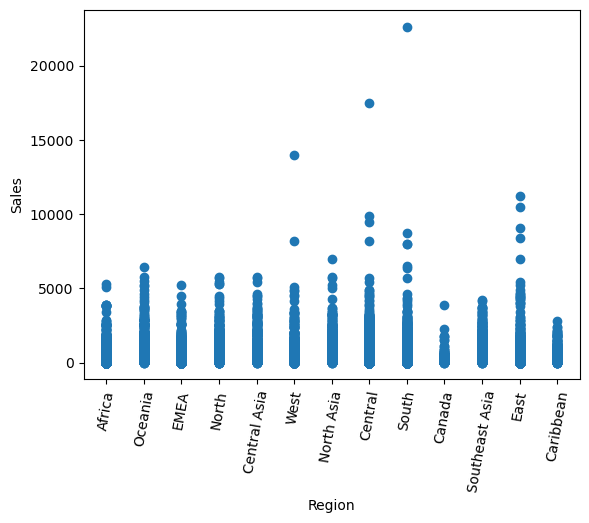

In [12]:
cur = conn.cursor()
cur.execute("SELECT Region, Sales FROM dataset;")
result = cur.fetchall()
Region = [r[0] for r in result]
Sales = [r[1] for r in result]

# Crie um gráfico de dispersão
plt.scatter(Region, Sales)
plt.xlabel('Region')
plt.ylabel('Sales')
plt.xticks(rotation=80)
plt.show()

In [13]:
cur.execute("SELECT `Delivery Time`, Quantity FROM dataset;")
result = cur.fetchall()
table = PrettyTable()
table.field_names = [desc[0] for desc in cur.description]
for row in result:
    table.add_row(row)
print (table)

+---------------+----------+
| Delivery Time | Quantity |
+---------------+----------+
|       5       |    2     |
|       7       |    3     |
|       4       |    4     |
|       4       |    3     |
|       7       |    5     |
|       7       |    2     |
|       2       |    2     |
|       2       |    2     |
|       3       |    1     |
|       2       |    3     |
|       4       |    5     |
|       5       |    2     |
|       5       |    6     |
|       2       |    5     |
|       2       |    3     |
|       5       |    2     |
|       4       |    3     |
|       2       |    5     |
|       2       |    3     |
|       2       |    1     |
|       6       |    3     |
|       6       |    2     |
|       5       |    6     |
|       3       |    4     |
|       5       |    3     |
|       4       |    6     |
|       4       |    8     |
|       4       |    6     |
|       3       |    4     |
|       5       |    5     |
|       4       |    6     |
|       2     

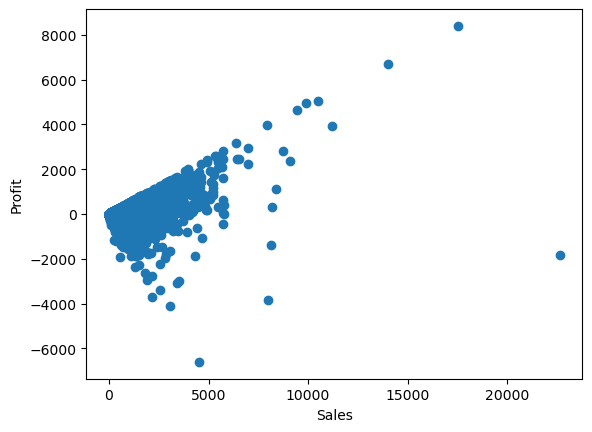

In [14]:
cur.execute("SELECT Sales,Profit FROM dataset;")
result = cur.fetchall()
sales = [r[0] for r in result]
profit = [r[1] for r in result]

# Crie um gráfico de dispersão
plt.scatter(sales, profit)
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()

In [15]:
# Verificando produtos mais vendidos
# with pd.option_context('display.max_rows', None):
print(df['Product Name'].value_counts())

Staples                                                                      227
Cardinal Index Tab, Clear                                                     92
Eldon File Cart, Single Width                                                 90
Rogers File Cart, Single Width                                                84
Ibico Index Tab, Clear                                                        83
                                                                            ... 
Okidata B401 Printer                                                           1
Snap-A-Way Black Print Carbonless Speed Message, No Reply Area, Duplicate      1
Xerox WorkCentre 6505DN Laser Multifunction Printer                            1
Barricks Round Table, Rectangular                                              1
Multimedia Mailers                                                             1
Name: Product Name, Length: 3788, dtype: int64


In [16]:
df.corr()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost,Delivery Time,priority_num
Row ID,1.000000,0.297431,-0.043889,-0.173483,0.087594,-0.019037,-0.039078,-0.018082,0.011609
Postal Code,0.297431,1.000000,-0.021402,0.059716,0.039499,-0.009549,-0.024620,-0.004974,0.007110
Sales,-0.043889,-0.021402,1.000000,0.313577,-0.086722,0.484918,0.768073,-0.004660,0.001656
Quantity,-0.173483,0.059716,0.313577,1.000000,-0.019875,0.104365,0.272649,0.004347,0.003328
Discount,0.087594,0.039499,-0.086722,-0.019875,1.000000,-0.316490,-0.079056,-0.001507,0.000269
Profit,-0.019037,-0.009549,0.484918,0.104365,-0.316490,1.000000,0.354441,0.001745,-0.002022
Shipping Cost,-0.039078,-0.024620,0.768073,0.272649,-0.079056,0.354441,1.000000,-0.142823,0.103446
Delivery Time,-0.018082,-0.004974,-0.004660,0.004347,-0.001507,0.001745,-0.142823,1.000000,-0.514669
priority_num,0.011609,0.007110,0.001656,0.003328,0.000269,-0.002022,0.103446,-0.514669,1.000000


### Desafio Machine Learning

In [19]:
df.to_csv('clean_data.csv', index = False)

data = pd.read_csv('clean_data.csv')
X = data[[ 'Sales', 'Quantity']]
y = data['Profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [21]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [22]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

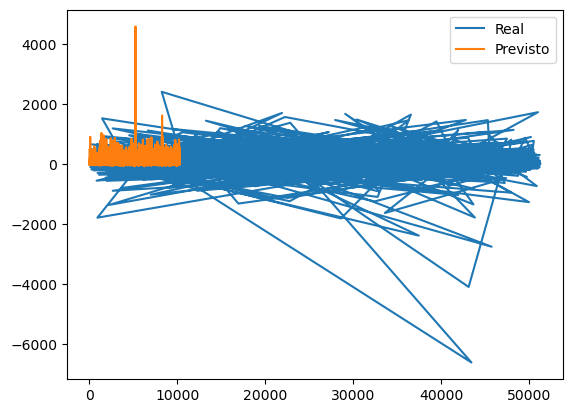

In [23]:
fig, ax = plt.subplots()
ax.plot(y_test, label='Real')
ax.plot(y_pred, label='Previsto')
ax.legend()
plt.show()